# TP05 - Exercice 4 : Apprentissage sensible aux coûts et calibration du seuil

### Noms eleve
Ethan TOMASO et julien TREMONT-RAIMI

**Objectifs :**
- Explorer des techniques avancées pour gérer le déséquilibre sans rééchantillonnage
- Utiliser la pondération des classes (class weighting)
- Optimiser le seuil de décision avec un DecisionTreeClassifier
- **Extension optionnelle :** Implémenter une fonction de coût personnalisée

In [1]:
# Imports nécessaires
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, auc, f1_score
)
from collections import Counter
import matplotlib.pyplot as plt

## 1. Chargement et création d'un déséquilibre artificiel

In [2]:
# 1. Chargement du dataset et création d'un déséquilibre artificiel
# Dataset Breast Cancer : prédiction du type de tumeur (maligne=0 ou bénigne=1)
X, y = load_breast_cancer(return_X_y=True)

print("=== Dataset Breast Cancer ===")
print(f"Nombre total d'échantillons : {len(X)}")
print(f"Nombre de features : {X.shape[1]}")

# Distribution originale
print("\nDistribution originale des classes:")
original_counts = Counter(y)
print(f"  Classe 0 (Maligne) : {original_counts[0]} échantillons")
print(f"  Classe 1 (Bénigne) : {original_counts[1]} échantillons")
print(f"  → Dataset relativement équilibré (ratio {original_counts[1]/original_counts[0]:.2f}:1)")

=== Dataset Breast Cancer ===
Nombre total d'échantillons : 569
Nombre de features : 30

Distribution originale des classes:
  Classe 0 (Maligne) : 212 échantillons
  Classe 1 (Bénigne) : 357 échantillons
  → Dataset relativement équilibré (ratio 1.68:1)


In [4]:
# Création d'un déséquilibre artificiel pour mieux illustrer les techniques
# On garde TOUS les échantillons de classe 0 (maligne) et seulement 20% de classe 1 (bénigne)
# Cela simule un contexte médical où les cas positifs (malins) sont plus fréquents

print("\n" + "="*70)
print("CRÉATION D'UN DÉSÉQUILIBRE ARTIFICIEL")
print("="*70)

idx_0 = np.where(y == 0)[0]  # Indices des tumeurs malignes
idx_1 = np.where(y == 1)[0]  # Indices des tumeurs bénignes

# Sous-échantillonnage : ne garder que 20% des échantillons de classe 1
n_keep_class1 = int(len(idx_1) * 0.2)
np.random.seed(42)
idx_1_keep = np.random.choice(idx_1, n_keep_class1, replace=False)

# Reconstruction du dataset déséquilibré
idx_keep = np.concatenate([idx_0, idx_1_keep])
np.random.shuffle(idx_keep)  # Mélange pour éviter un ordre biaisé
X_res = X[idx_keep]
y_res = y[idx_keep]

print(f"\nDistribution APRÈS création du déséquilibre :")
new_counts = Counter(y_res)
print(f"  Classe 0 (Maligne) : {new_counts[0]} échantillons")
print(f"  Classe 1 (Bénigne) : {new_counts[1]} échantillons")
imbalance_ratio = new_counts[0] / new_counts[1]
print(f"  Ratio de déséquilibre : {imbalance_ratio:.2f}:1")
print(f"Interprétation : Pour chaque tumeur bénigne, il y a ~{imbalance_ratio:.0f} tumeurs malignes.")
print("    Ce déséquilibre nécessite des techniques spéciales pour éviter un biais du modèle.")


CRÉATION D'UN DÉSÉQUILIBRE ARTIFICIEL

Distribution APRÈS création du déséquilibre :
  Classe 0 (Maligne) : 212 échantillons
  Classe 1 (Bénigne) : 71 échantillons
  Ratio de déséquilibre : 2.99:1
Interprétation : Pour chaque tumeur bénigne, il y a ~3 tumeurs malignes.
    Ce déséquilibre nécessite des techniques spéciales pour éviter un biais du modèle.


In [5]:
# Division train/test avec stratification (30% pour le test)
# La stratification maintient les proportions de classes dans train et test
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

print("\n=== Division Train/Test ===")
print(f"Train set : {len(X_train)} échantillons - Distribution : {Counter(y_train)}")
print(f"Test set  : {len(X_test)} échantillons - Distribution : {Counter(y_test)}")
print("\nLa stratification garantit que train et test ont des proportions de classes similaires.")


=== Division Train/Test ===
Train set : 198 échantillons - Distribution : Counter({0: 148, 1: 50})
Test set  : 85 échantillons - Distribution : Counter({0: 64, 1: 21})

La stratification garantit que train et test ont des proportions de classes similaires.


## 2. Entraînement du modèle par défaut (sans pondération)

In [6]:
# 2. Entraînement d'un DecisionTree SANS pondération de classes (baseline)
print("\n" + "="*70)
print("MODÈLE 1 : DecisionTree PAR DÉFAUT (sans pondération)")
print("="*70)

print("\nConfiguration :")
print("  - Pas de pondération des classes (class_weight=None)")
print("  - Le modèle traite toutes les erreurs de manière égale")
print("  - Conséquence : Risque de biais vers la classe majoritaire (0)")

tree_default = DecisionTreeClassifier(random_state=42)
tree_default.fit(X_train, y_train)

print("\n✓ Modèle entraîné avec succès")


MODÈLE 1 : DecisionTree PAR DÉFAUT (sans pondération)

Configuration :
  - Pas de pondération des classes (class_weight=None)
  - Le modèle traite toutes les erreurs de manière égale
  - Conséquence : Risque de biais vers la classe majoritaire (0)

✓ Modèle entraîné avec succès


## 3. Entraînement du modèle avec pondération équilibrée

In [7]:
# 3. Entraînement d'un DecisionTree AVEC pondération équilibrée
print("\n" + "="*70)
print("MODÈLE 2 : DecisionTree AVEC PONDÉRATION (class_weight='balanced')")
print("="*70)

print("\nConfiguration :")
print("  - class_weight='balanced'")
print("  - Calcul automatique des poids : weight_class_i = n_samples / (n_classes * n_samples_class_i)")
print("  - Effet : Les erreurs sur la classe minoritaire sont plus pénalisées")
print("  - Objectif : Forcer le modèle à mieux apprendre la classe minoritaire")

# Calcul explicite des poids pour information
n_samples = len(y_train)
n_classes = len(np.unique(y_train))
counts_train = Counter(y_train)
weight_0 = n_samples / (n_classes * counts_train[0])
weight_1 = n_samples / (n_classes * counts_train[1])

print(f"\nPoids calculés :")
print(f"  - Poids classe 0 (majoritaire) : {weight_0:.3f}")
print(f"  - Poids classe 1 (minoritaire)  : {weight_1:.3f}")
print(f"  → La classe minoritaire a un poids {weight_1/weight_0:.1f}x plus élevé")

tree_weighted = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_weighted.fit(X_train, y_train)

print("\n✓ Modèle entraîné avec succès")


MODÈLE 2 : DecisionTree AVEC PONDÉRATION (class_weight='balanced')

Configuration :
  - class_weight='balanced'
  - Calcul automatique des poids : weight_class_i = n_samples / (n_classes * n_samples_class_i)
  - Effet : Les erreurs sur la classe minoritaire sont plus pénalisées
  - Objectif : Forcer le modèle à mieux apprendre la classe minoritaire

Poids calculés :
  - Poids classe 0 (majoritaire) : 0.669
  - Poids classe 1 (minoritaire)  : 1.980
  → La classe minoritaire a un poids 3.0x plus élevé

✓ Modèle entraîné avec succès


## 4. Fonction d'évaluation et comparaison des modèles

In [8]:
# 4. Fonction d'évaluation complète
def evaluate_model(model, X_test, y_test, label="Model"):
    """
    Évalue un modèle et calcule toutes les métriques nécessaires.
    
    Retourne :
        - y_proba : probabilités prédites pour la classe positive
        - auc_roc : aire sous la courbe ROC
        - auc_pr : aire sous la courbe Précision-Rappel
        - pr_data : données pour la courbe Précision-Rappel (precision, recall, thresholds)
    """
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Calcul des courbes
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    auc_roc = auc(fpr, tpr)
    auc_pr = auc(recall, precision)
    
    print(f"\n=== {label} ===")
    print(classification_report(y_test, y_pred, digits=3, target_names=['Maligne (0)', 'Bénigne (1)']))
    
    print("Matrice de Confusion :")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"  TN={cm[0,0]} (Vrais Négatifs)   | FP={cm[0,1]} (Faux Positifs)")
    print(f"  FN={cm[1,0]} (Faux Négatifs)    | TP={cm[1,1]} (Vrais Positifs)")
    
    print(f"\nAUC (ROC) : {auc_roc:.3f}")
    print(f"AUC (PR)  : {auc_pr:.3f}")
    
    return y_proba, auc_roc, auc_pr, (precision, recall, thresholds), cm

# Évaluation des deux modèles
print("\n" + "="*70)
print("ÉVALUATION ET COMPARAISON DES MODÈLES")
print("="*70)

y_proba_default, auc_roc_default, auc_pr_default, pr_data_default, cm_default = evaluate_model(
    tree_default, X_test, y_test, "Modèle 1 : DecisionTree par défaut"
)

y_proba_weighted, auc_roc_weighted, auc_pr_weighted, pr_data_weighted, cm_weighted = evaluate_model(
    tree_weighted, X_test, y_test, "Modèle 2 : DecisionTree avec pondération"
)


ÉVALUATION ET COMPARAISON DES MODÈLES

=== Modèle 1 : DecisionTree par défaut ===
              precision    recall  f1-score   support

 Maligne (0)      0.954     0.969     0.961        64
 Bénigne (1)      0.900     0.857     0.878        21

    accuracy                          0.941        85
   macro avg      0.927     0.913     0.920        85
weighted avg      0.941     0.941     0.941        85

Matrice de Confusion :
[[62  2]
 [ 3 18]]
  TN=62 (Vrais Négatifs)   | FP=2 (Faux Positifs)
  FN=3 (Faux Négatifs)    | TP=18 (Vrais Positifs)

AUC (ROC) : 0.913
AUC (PR)  : 0.896

=== Modèle 2 : DecisionTree avec pondération ===
              precision    recall  f1-score   support

 Maligne (0)      0.954     0.969     0.961        64
 Bénigne (1)      0.900     0.857     0.878        21

    accuracy                          0.941        85
   macro avg      0.927     0.913     0.920        85
weighted avg      0.941     0.941     0.941        85

Matrice de Confusion :
[[62  2]
 

## 5. Visualisation des courbes ROC et Précision-Rappel


VISUALISATION DES COURBES DE PERFORMANCE

Interprétation de la courbe ROC :
  - Plus l'AUC est proche de 1.0, meilleure est la capacité de discrimination.
  - AUC = 0.5 correspond à un classifieur aléatoire (ligne diagonale).
  - La courbe montre le compromis entre TPR (sensibilité) et FPR pour tous les seuils.

Interprétation de la courbe Précision-Rappel :
  - Plus appropriée que ROC pour les données très déséquilibrées.
  - Montre le compromis entre Précision (fiabilité) et Recall (couverture).
  - Une courbe proche du coin supérieur droit est idéale.


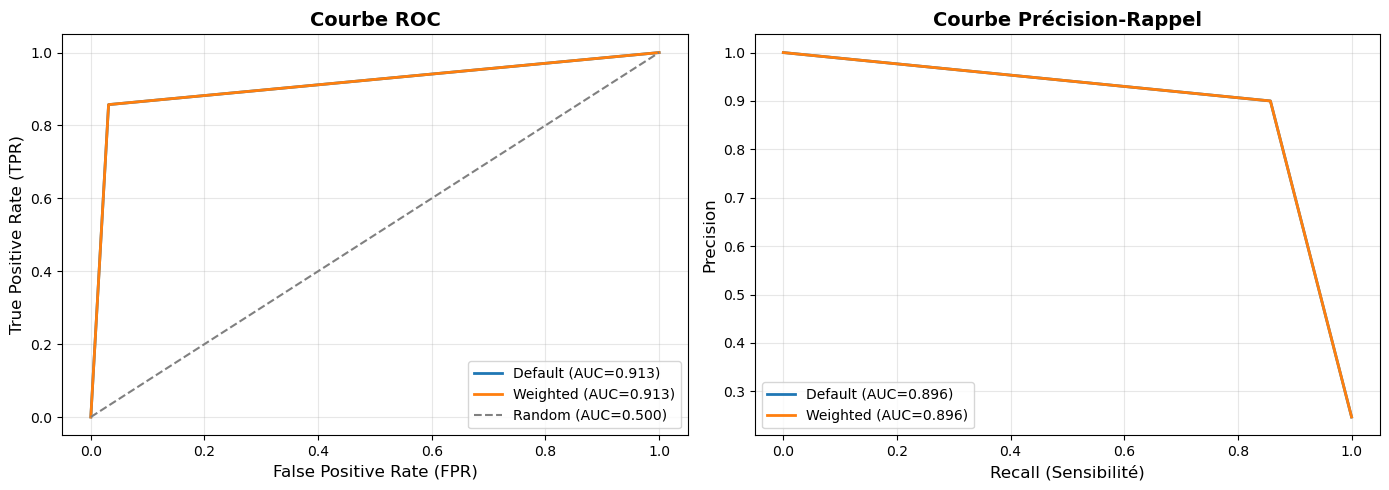

In [9]:
# 5. Visualisation des courbes ROC et Précision-Rappel
print("\n" + "="*70)
print("VISUALISATION DES COURBES DE PERFORMANCE")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Courbe ROC
ax = axes[0]
fpr_d, tpr_d, _ = roc_curve(y_test, y_proba_default)
fpr_w, tpr_w, _ = roc_curve(y_test, y_proba_weighted)
ax.plot(fpr_d, tpr_d, label=f"Default (AUC={auc_roc_default:.3f})", linewidth=2)
ax.plot(fpr_w, tpr_w, label=f"Weighted (AUC={auc_roc_weighted:.3f})", linewidth=2)
ax.plot([0, 1], [0, 1], '--', color='gray', label='Random (AUC=0.500)')
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=12)
ax.set_title('Courbe ROC', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

print("\nInterprétation de la courbe ROC :")
print("  - Plus l'AUC est proche de 1.0, meilleure est la capacité de discrimination.")
print("  - AUC = 0.5 correspond à un classifieur aléatoire (ligne diagonale).")
print("  - La courbe montre le compromis entre TPR (sensibilité) et FPR pour tous les seuils.")

# (b) Courbe Précision-Rappel
ax = axes[1]
prec_d, rec_d, _ = pr_data_default
prec_w, rec_w, _ = pr_data_weighted
ax.plot(rec_d, prec_d, label=f"Default (AUC={auc_pr_default:.3f})", linewidth=2)
ax.plot(rec_w, prec_w, label=f"Weighted (AUC={auc_pr_weighted:.3f})", linewidth=2)
ax.set_xlabel('Recall (Sensibilité)', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Courbe Précision-Rappel', fontsize=14, fontweight='bold')
ax.legend(loc='lower left')
ax.grid(alpha=0.3)

print("\nInterprétation de la courbe Précision-Rappel :")
print("  - Plus appropriée que ROC pour les données très déséquilibrées.")
print("  - Montre le compromis entre Précision (fiabilité) et Recall (couverture).")
print("  - Une courbe proche du coin supérieur droit est idéale.")

plt.tight_layout()
plt.show()

## 6. Optimisation du seuil de décision

In [10]:
# 6. Calibration du seuil de décision pour maximiser le F1-Score
print("\n" + "="*70)
print("CALIBRATION DU SEUIL DE DÉCISION")
print("="*70)

print("""
CONTEXTE :
Par défaut, les classificateurs utilisent un seuil de 0.5 pour convertir les probabilités
en prédictions binaires. Cependant, ce seuil n'est pas optimal pour toutes les situations,
surtout avec des classes déséquilibrées.

OBJECTIF :
Trouver le seuil optimal qui maximise le F1-Score (ou une autre métrique selon le contexte).

CONTEXTE MÉDICAL :
- Faux Négatif (FN) : Prédire une tumeur bénigne alors qu'elle est maligne
  → TRÈS GRAVE : Patient non traité, risque vital
  
- Faux Positif (FP) : Prédire une tumeur maligne alors qu'elle est bénigne
  → MOINS GRAVE : Examens supplémentaires, stress, mais pas de risque vital

→ Dans ce contexte, on privilégie un RECALL élevé (détecter tous les cas malins)
  même si cela augmente légèrement les faux positifs.
""")

# Optimisation du seuil sur le modèle avec pondération (généralement meilleur)
precision, recall, thresholds = pr_data_weighted

# Calcul du F1-Score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # +epsilon pour éviter division par 0

# Identification du seuil optimal
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
best_precision = precision[best_idx]
best_recall = recall[best_idx]

print(f"\n=== Résultats de l'optimisation ===")
print(f"Seuil optimal (pour max F1-Score) : {best_threshold:.3f}")
print(f"F1-Score optimal                  : {best_f1:.3f}")
print(f"Précision au seuil optimal        : {best_precision:.3f}")
print(f"Recall au seuil optimal           : {best_recall:.3f}")

# Seuil pour maximiser le Recall (contexte médical)
# On cherche un recall élevé (ex: >0.95) avec la meilleure précision possible
target_recall = 0.95
valid_indices = np.where(recall >= target_recall)[0]
if len(valid_indices) > 0:
    recall_optimal_idx = valid_indices[np.argmax(precision[valid_indices])]
    recall_optimal_threshold = thresholds[recall_optimal_idx]
    recall_optimal_precision = precision[recall_optimal_idx]
    recall_optimal_recall = recall[recall_optimal_idx]
    
    print(f"\n=== Seuil optimisé pour le contexte médical ===")
    print(f"Objectif : Recall ≥ {target_recall}")
    print(f"Seuil optimal (max recall)        : {recall_optimal_threshold:.3f}")
    print(f"Précision obtenue                 : {recall_optimal_precision:.3f}")
    print(f"Recall obtenu                     : {recall_optimal_recall:.3f}")
    print(f"  → Ce seuil minimise les faux négatifs (tumeurs malignes non détectées)")


CALIBRATION DU SEUIL DE DÉCISION

CONTEXTE :
Par défaut, les classificateurs utilisent un seuil de 0.5 pour convertir les probabilités
en prédictions binaires. Cependant, ce seuil n'est pas optimal pour toutes les situations,
surtout avec des classes déséquilibrées.

OBJECTIF :
Trouver le seuil optimal qui maximise le F1-Score (ou une autre métrique selon le contexte).

CONTEXTE MÉDICAL :
- Faux Négatif (FN) : Prédire une tumeur bénigne alors qu'elle est maligne
  → TRÈS GRAVE : Patient non traité, risque vital
  
- Faux Positif (FP) : Prédire une tumeur maligne alors qu'elle est bénigne
  → MOINS GRAVE : Examens supplémentaires, stress, mais pas de risque vital

→ Dans ce contexte, on privilégie un RECALL élevé (détecter tous les cas malins)
  même si cela augmente légèrement les faux positifs.


=== Résultats de l'optimisation ===
Seuil optimal (pour max F1-Score) : 1.000
F1-Score optimal                  : 0.878
Précision au seuil optimal        : 0.900
Recall au seuil optimal     

In [12]:
# 7. Application du seuil calibré et comparaison
print("\n" + "="*70)
print("APPLICATION DU SEUIL CALIBRÉ")
print("="*70)

# Prédictions avec le seuil par défaut (0.5)
y_pred_default_threshold = tree_weighted.predict(X_test)

# Prédictions avec le seuil calibré (optimisé pour F1)
y_pred_calibrated = (y_proba_weighted >= best_threshold).astype(int)

print("\n--- Modèle avec pondération + Seuil par défaut (0.5) ---")
cm_before = confusion_matrix(y_test, y_pred_default_threshold)
print(classification_report(y_test, y_pred_default_threshold, digits=3, target_names=['Maligne (0)', 'Bénigne (1)']))
print("Matrice de Confusion :")
print(cm_before)
print(f"Faux Négatifs (FN) : {cm_before[1,0]} | Faux Positifs (FP) : {cm_before[0,1]}")

print("\n--- Modèle avec pondération + Seuil calibré ({:.3f}) ---".format(best_threshold))
cm_after = confusion_matrix(y_test, y_pred_calibrated)
print(classification_report(y_test, y_pred_calibrated, digits=3, target_names=['Maligne (0)', 'Bénigne (1)']))
print("Matrice de Confusion :")
print(cm_after)
print(f"Faux Négatifs (FN) : {cm_after[1,0]} | Faux Positifs (FP) : {cm_after[0,1]}")

# Analyse de l'impact
print("\n" + "="*70)
print("ANALYSE DE L'IMPACT DU SEUIL CALIBRÉ")
print("="*70)

fn_diff = cm_after[1,0] - cm_before[1,0]
fp_diff = cm_after[0,1] - cm_before[0,1]

print(f"\nChangement des erreurs :")
print(f"  Faux Négatifs (FN) : {cm_before[1,0]} → {cm_after[1,0]} ({fn_diff:+d})")
print(f"  Faux Positifs (FP) : {cm_before[0,1]} → {cm_after[0,1]} ({fp_diff:+d})")

print("\nINTERPRÉTATION :")
if fn_diff < 0:
    print(f"  ✓ Réduction de {abs(fn_diff)} faux négatifs (tumeurs malignes non détectées)")
    print("    → Amélioration de la SÉCURITÉ du diagnostic")
if fp_diff > 0:
    print(f"  ⚠  Augmentation de {fp_diff} faux positifs (fausses alarmes)")
    print("    → Mais c'est un compromis acceptable dans un contexte médical")
    print("       (mieux vaut un examen supplémentaire qu'un cancer non détecté)")

print("\nCONCLUSION :")
print("  La calibration du seuil permet d'adapter le modèle au contexte d'application.")
print("  Dans le diagnostic médical, on privilégie un recall élevé pour minimiser")
print("  les risques, même si cela augmente légèrement les faux positifs.")


APPLICATION DU SEUIL CALIBRÉ

--- Modèle avec pondération + Seuil par défaut (0.5) ---
              precision    recall  f1-score   support

 Maligne (0)      0.954     0.969     0.961        64
 Bénigne (1)      0.900     0.857     0.878        21

    accuracy                          0.941        85
   macro avg      0.927     0.913     0.920        85
weighted avg      0.941     0.941     0.941        85

Matrice de Confusion :
[[62  2]
 [ 3 18]]
Faux Négatifs (FN) : 3 | Faux Positifs (FP) : 2

--- Modèle avec pondération + Seuil calibré (1.000) ---
              precision    recall  f1-score   support

 Maligne (0)      0.954     0.969     0.961        64
 Bénigne (1)      0.900     0.857     0.878        21

    accuracy                          0.941        85
   macro avg      0.927     0.913     0.920        85
weighted avg      0.941     0.941     0.941        85

Matrice de Confusion :
[[62  2]
 [ 3 18]]
Faux Négatifs (FN) : 3 | Faux Positifs (FP) : 2

ANALYSE DE L'IMPACT 

## 8. Visualisation de la structure de l'arbre de décision


VISUALISATION DE L'ARBRE DE DÉCISION

La visualisation de l'arbre permet de comprendre comment la pondération des classes
influence les frontières de décision apprises.

Observations à rechercher :
- Les valeurs dans les nœuds montrent la distribution des classes
- Avec pondération, l'arbre peut créer plus de branches pour mieux séparer
  la classe minoritaire, même si cela réduit légèrement la pureté globale



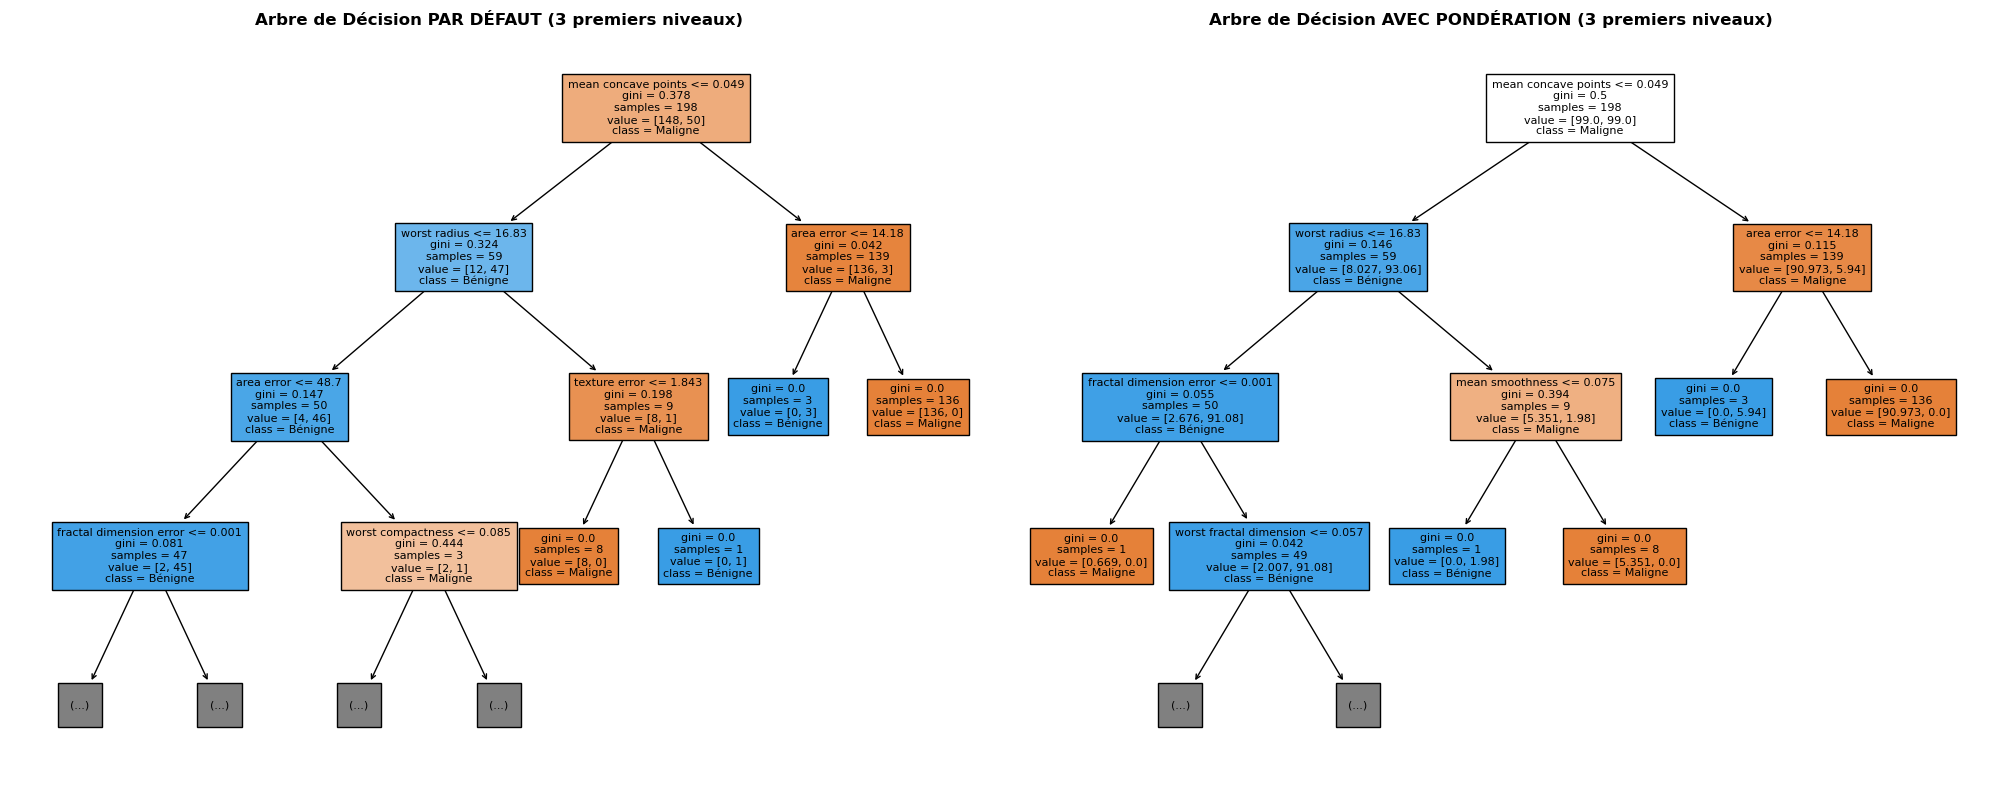


Légende :
  - Couleur : Classe majoritaire dans le nœud (orange=0, bleu=1)
  - Intensité : Pureté du nœud (plus foncé = plus pur)
  - value : Distribution des échantillons [classe_0, classe_1]


In [13]:
# 8. Visualisation de la structure de l'arbre de décision
print("\n" + "="*70)
print("VISUALISATION DE L'ARBRE DE DÉCISION")
print("="*70)

print("""
La visualisation de l'arbre permet de comprendre comment la pondération des classes
influence les frontières de décision apprises.

Observations à rechercher :
- Les valeurs dans les nœuds montrent la distribution des classes
- Avec pondération, l'arbre peut créer plus de branches pour mieux séparer
  la classe minoritaire, même si cela réduit légèrement la pureté globale
""")

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
feature_names = load_breast_cancer().feature_names

# Arbre par défaut
ax = axes[0]
plot_tree(tree_default, filled=True, feature_names=feature_names, 
          class_names=['Maligne', 'Bénigne'], max_depth=3, ax=ax, fontsize=8)
ax.set_title('Arbre de Décision PAR DÉFAUT (3 premiers niveaux)', fontsize=12, fontweight='bold')

# Arbre avec pondération
ax = axes[1]
plot_tree(tree_weighted, filled=True, feature_names=feature_names,
          class_names=['Maligne', 'Bénigne'], max_depth=3, ax=ax, fontsize=8)
ax.set_title('Arbre de Décision AVEC PONDÉRATION (3 premiers niveaux)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nLégende :")
print("  - Couleur : Classe majoritaire dans le nœud (orange=0, bleu=1)")
print("  - Intensité : Pureté du nœud (plus foncé = plus pur)")
print("  - value : Distribution des échantillons [classe_0, classe_1]")

## EXTENSION OPTIONNELLE : Fonction de coût personnalisée

Dans cette section, nous implémentons une fonction de coût personnalisée où les **faux négatifs sont pénalisés 10 fois plus** que les faux positifs, reflétant le contexte médical où manquer un cancer est beaucoup plus grave qu'une fausse alerte.

In [ ]:
# EXTENSION OPTIONNELLE : Fonction de coût personnalisée
print("\n" + "="*70)
print("EXTENSION OPTIONNELLE : FONCTION DE COÛT PERSONNALISÉE")
print("="*70)

print("""
CONTEXTE :
Dans le diagnostic médical, toutes les erreurs n'ont pas le même impact :
- Faux Négatif (FN) : Ne pas détecter un cancer → Risque vital élevé
- Faux Positif (FP) : Fausse alerte → Examens supplémentaires, stress

FONCTION DE COÛT PERSONNALISÉE :
Nous définissons une fonction où :
- Coût d'un Faux Négatif = 10 unités
- Coût d'un Faux Positif = 1 unité
- Coût d'une prédiction correcte = 0

→ Cette pénalisation asymétrique reflète mieux les priorités médicales.
""")

def custom_cost_function(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcule le coût total basé sur une matrice de coûts personnalisée.
    
    Paramètres :
        y_true : vraies étiquettes
        y_pred : étiquettes prédites
        cost_fn : coût d'un faux négatif (défaut: 10)
        cost_fp : coût d'un faux positif (défaut: 1)
    
    Retourne :
        total_cost : coût total
        breakdown : détail des coûts par type d'erreur
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraction des composantes de la matrice de confusion
    tn, fp, fn, tp = cm.ravel()
    
    # Calcul des coûts
    cost_false_negatives = fn * cost_fn
    cost_false_positives = fp * cost_fp
    total_cost = cost_false_negatives + cost_false_positives
    
    # Normalisation par le nombre total d'échantillons pour comparabilité
    normalized_cost = total_cost / len(y_true)
    
    breakdown = {
        'FN_count': fn,
        'FP_count': fp,
        'FN_cost': cost_false_negatives,
        'FP_cost': cost_false_positives,
        'total_cost': total_cost,
        'normalized_cost': normalized_cost
    }
    
    return total_cost, breakdown

print("\n✓ Fonction de coût personnalisée définie")

In [ ]:
# Application de la fonction de coût aux différents modèles
print("\n" + "="*70)
print("COMPARAISON DES MODÈLES SELON LE COÛT PERSONNALISÉ")
print("="*70)

# Évaluation de tous les modèles/configurations testés
models_to_evaluate = [
    ("DecisionTree par défaut (seuil 0.5)", tree_default.predict(X_test)),
    ("DecisionTree avec pondération (seuil 0.5)", tree_weighted.predict(X_test)),
    ("DecisionTree avec pondération + Seuil calibré", y_pred_calibrated)
]

results_cost = []

for model_name, y_pred in models_to_evaluate:
    total_cost, breakdown = custom_cost_function(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n--- {model_name} ---")
    print(f"  Faux Négatifs (FN) : {breakdown['FN_count']} → Coût : {breakdown['FN_cost']} unités")
    print(f"  Faux Positifs (FP) : {breakdown['FP_count']} → Coût : {breakdown['FP_cost']} unités")
    print(f"  Coût total         : {breakdown['total_cost']} unités")
    print(f"  Coût normalisé     : {breakdown['normalized_cost']:.3f} (par échantillon)")
    print(f"  F1-Score           : {f1:.3f}")
    
    results_cost.append({
        'Model': model_name,
        'FN': breakdown['FN_count'],
        'FP': breakdown['FP_count'],
        'Total_Cost': breakdown['total_cost'],
        'Normalized_Cost': breakdown['normalized_cost'],
        'F1_Score': f1
    })

# Tableau comparatif
df_cost = pd.DataFrame(results_cost)
print("\n" + "="*70)
print("TABLEAU RÉCAPITULATIF")
print("="*70)
print("\n", df_cost[['Model', 'FN', 'FP', 'Total_Cost', 'Normalized_Cost', 'F1_Score']].to_string(index=False))

In [ ]:
# Visualisation de la comparaison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Comparaison Coût vs F1-Score
ax = axes[0]
x = np.arange(len(df_cost))
width = 0.35

# Normalisation du coût pour visualisation (échelle 0-1)
normalized_costs_for_viz = df_cost['Normalized_Cost'] / df_cost['Normalized_Cost'].max()

bars1 = ax.bar(x - width/2, normalized_costs_for_viz, width, label='Coût normalisé', alpha=0.8, color='crimson')
bars2 = ax.bar(x + width/2, df_cost['F1_Score'], width, label='F1-Score', alpha=0.8, color='steelblue')

ax.set_xlabel('Modèle')
ax.set_ylabel('Score (normalisé)')
ax.set_title('Comparaison : Coût personnalisé vs F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(['Default', 'Weighted', 'Weighted+Calibré'], rotation=20, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

# (b) Décomposition du coût (FN vs FP)
ax = axes[1]
fn_costs = df_cost['FN'] * 10
fp_costs = df_cost['FP'] * 1

bars1 = ax.bar(x, fn_costs, width, label='Coût FN (×10)', alpha=0.8, color='darkred')
bars2 = ax.bar(x, fp_costs, width, bottom=fn_costs, label='Coût FP (×1)', alpha=0.8, color='orange')

ax.set_xlabel('Modèle')
ax.set_ylabel('Coût total (unités)')
ax.set_title('Décomposition du coût par type d\'erreur')
ax.set_xticks(x)
ax.set_xticklabels(['Default', 'Weighted', 'Weighted+Calibré'], rotation=20, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Analyse finale
print("\n" + "="*70)
print("ANALYSE FINALE : COÛT PERSONNALISÉ vs F1-SCORE")
print("="*70)

print("""
OBSERVATIONS :

1. DIFFÉRENCE ENTRE F1-SCORE ET COÛT PERSONNALISÉ :
   
   - F1-Score : Traite les faux positifs et faux négatifs de manière égale.
                C'est une moyenne harmonique de la précision et du recall.
   
   - Coût Personnalisé : Reflète les priorités réelles du contexte d'application.
                          Dans notre cas, un FN coûte 10× plus qu'un FP.

2. POURQUOI LES CLASSEMENTS PEUVENT DIFFÉRER :
   
   Un modèle peut avoir un excellent F1-Score mais un coût élevé si il produit
   quelques faux négatifs (très pénalisés dans notre fonction de coût).
   
   Inversement, un modèle avec un F1 légèrement inférieur mais zéro FN aura
   un coût beaucoup plus faible.

3. RECOMMANDATIONS :
   
   - Pour des applications critiques (médical, sécurité), utilisez une fonction
     de coût personnalisée qui reflète les véritables priorités.
   
   - Le F1-Score reste utile comme métrique générale, mais ne remplace pas
     une évaluation basée sur les coûts réels.
   
   - L'optimisation du seuil de décision est cruciale pour minimiser le coût
     dans un contexte spécifique.
""")

# Identification du meilleur modèle selon chaque critère
best_f1_model = df_cost.loc[df_cost['F1_Score'].idxmax(), 'Model']
best_cost_model = df_cost.loc[df_cost['Total_Cost'].idxmin(), 'Model']

print(f"\nMeilleur modèle selon le F1-Score : {best_f1_model}")
print(f"Meilleur modèle selon le Coût     : {best_cost_model}")

if best_f1_model != best_cost_model:
    print("\n⚠️  ATTENTION : Les deux critères ne donnent pas le même modèle optimal !")
    print("    → Choisissez selon les priorités de votre application.")
else:
    print("\n✓ Les deux critères convergent vers le même modèle optimal.")

print("\n" + "="*70)
print("EXERCICE 4 TERMINÉ (avec extension optionnelle)")
print("="*70)